# Translating a Landlab RasterModelGrid into a PyVista StructuredGrid for visualization

*Greg Tucker, CU Boulder, June 2025*

PyVista offers powerful 3D visualization capabilities for geoscientific data. This notebook demonstrates how to use a set of utilities I've written that translate data from a Landlab `RasterModelGrid` and its fields into a PyVista `StructuredGrid`, which can then be visualized interactively directly in a notebook.

For a `RasterModelGrid`, the package offers two closely related functions:

- `raster_grid_to_pv2d_struct` creates a 2D mesh surface
- `raster_grid_to_pv3d_struct` creates a 3D mesh, with two levels: the topography on top, and (by default) a flat base on the bottom

Start with some imports:

In [1]:
import numpy as np
import pyvista as pv
from llpvtools import grid_to_pv
from landlab import RasterModelGrid, imshow_grid

## Creating a simple example

Here we'll use the same example that appears in one of the PyVista tutorials, but here created initially as a landlab `RasterModelGrid`. We'll assign two fields: the topographic elevation (which will be the $z$ coordinate for our surface), and the gradient. 

To illustrate use of *corners* instead of *nodes*, we'll also assign a field for elevation and gradient values at corners.

In [2]:
rmg = RasterModelGrid((80, 80), 0.25, xy_of_lower_left=(-10.0, -10.0))

z = rmg.add_zeros("topographic__elevation", at="node")
s = rmg.add_zeros("topographic__gradient", at="node")
zc = rmg.add_zeros("z_at_corners", at="corner")
sc = rmg.add_zeros("gradient_at_corners", at="corner")

# Create a rippled surface, same as in PyVista tutorial
x = rmg.x_of_node
y = rmg.y_of_node
r = np.sqrt(x**2 + y**2)
z[:] = np.sin(r)

# Calculate the gradient in the y-direction
dy, _ = np.gradient(z.reshape((80, 80)))
s[:] = dy.flatten()

# Rippled surface for corners
xc = rmg.x_of_corner
yc = rmg.y_of_corner
rc = np.sqrt(xc**2 + yc**2)
zc[:] = np.sin(rc)

# and gradient
dyc, _ = np.gradient(zc.reshape((79, 79)))
sc[:] = dyc.flatten()

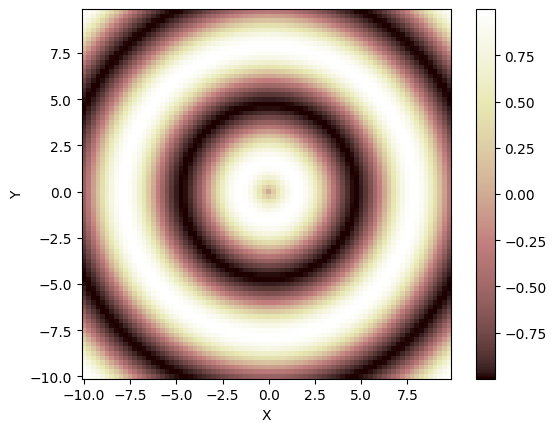

In [3]:
imshow_grid(rmg, z)

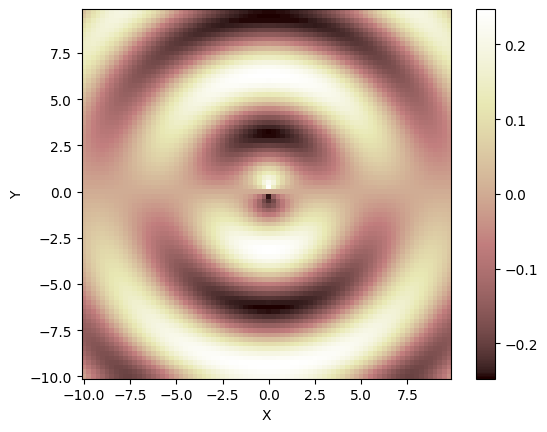

In [4]:
imshow_grid(rmg, s)

## Visualizing a landlab raster grid as a 2D surface

The function `raster_grid_to_pv2d_struct` creates a 2D PyVista `StructuredGrid`, representing a surface. The grid's fields are included in the data structure as **Data Arrays**.

In [6]:
node_mesh, cnr_mesh = grid_to_pv(
    rmg, field_for_node_z="topographic__elevation", field_for_corner_z="z_at_corners"
)
node_mesh

StructuredGrid (0x1206cc9a0)
  N Cells:      6241
  N Points:     6400
  X Bounds:     -1.000e+01, 9.750e+00
  Y Bounds:     -1.000e+01, 9.750e+00
  Z Bounds:     -1.000e+00, 1.000e+00
  Dimensions:   80, 80, 1
  N Arrays:     2

In [7]:
node_mesh.plot(show_edges=True)

Widget(value='<iframe src="http://localhost:50723/index.html?ui=P_0x11d4fda90_0&reconnect=auto" class="pyvista…

To color by a different field, use the `set_active_scalars()` method:

In [8]:
node_mesh.set_active_scalars('topographic__gradient')
node_mesh.plot(show_edges=True)

Widget(value='<iframe src="http://localhost:50723/index.html?ui=P_0x123db7d90_1&reconnect=auto" class="pyvista…

We can also deactivate coloring:

In [9]:
node_mesh.set_active_scalars(None)
node_mesh.plot(show_edges=True)

Widget(value='<iframe src="http://localhost:50723/index.html?ui=P_0x123eb2710_2&reconnect=auto" class="pyvista…

The above examples use the landlab grid's *nodes* and *patches*. We can also use *corners* and *cells*. This generates a mesh of 79 by 79 points, since that's the shape of *corners* in our grid (one fewer than nodes in each dimension).

In [11]:
cnr_mesh

StructuredGrid (0x1206cc820)
  N Cells:      6084
  N Points:     6241
  X Bounds:     -9.875e+00, 9.625e+00
  Y Bounds:     -9.875e+00, 9.625e+00
  Z Bounds:     -1.000e+00, 1.000e+00
  Dimensions:   79, 79, 1
  N Arrays:     2

In [12]:
cnr_mesh.plot(show_edges=True)

Widget(value='<iframe src="http://localhost:50723/index.html?ui=P_0x12b7a4cd0_3&reconnect=auto" class="pyvista…

## Created a 3D mesh object

The function `raster_grid_to_pv3d_struct` is quite similar, but it creates a fully 3D mesh. The mesh consists of two layers. The top layer is the topography (or, more generally, whatever field we happened to use for the $z$ coordinate). The bottom layer is flat, and located by default a distance $h$ below the lowest surface point, where $h$ is half the widest extent of the grid. (You can override this by passing a different `depth` value (measured downward from $z=0$).

In [ ]:
strucgrid_3d_nodes = raster_grid_to_pv3d_struct(rmg, "topographic__elevation")
strucgrid_3d_nodes

In [ ]:
strucgrid_3d_nodes.plot(show_edges=True)

## Combining node-link-patch and corner-face-cell meshes in a Plotter

The example below plots both of the Landlab dual meshes together: the nodes-links-patches mesh and the corners-faces-cells mesh. In this example, nodes are shown in black, links in red, faces in blue.

In [ ]:
pl = pv.Plotter()
pl.add_mesh(strucgrid_2d_nodes, color="red", style="wireframe", line_width=1)
pl.add_mesh(strucgrid_2d_corners, color="blue", style="wireframe", line_width=1)
pl.add_points(
    strucgrid_2d_nodes.points, color='black', point_size=4, render_points_as_spheres=True
)
pl.show()

## Options

The function signatures for the two landlab-to-pyvista raster conversion functions illustrate the available optional parameters:

In [ ]:
help(raster_grid_to_pv2d_struct)

In [ ]:
help(raster_grid_to_pv3d_struct)

Coming soon (geologically), I hope, will be:

- Functions to do similar translation for other Landlab grid types
- Examples of how to read Landlab output in .vtk format directly into a PyVista data structure
- Function(s) to translate a grid into a compound PyVista data structure that includes both node/patch and corner/cell geometry
- The ability to translate fields on cells or patches
- Some kind of widget-like tools to flip between different fields
- A function to compile multiple fields-as-surfaces; for example `topographic__elevation` and `bedrock_surface__elevation` might both represent meaningful surfaces to be plotted together
- A way to provide time-animation
- A function to represent a drainage network as a mesh of line segments
- A way to include vector data using arrow glyphs or similar (e.g., flow velocity, sediment transport, etc.)
- EPIC: a reasonably comprehensive visualization tool/widget-set for visualizing landlab output generally